In [1]:
#必要なパッケージのインポート

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import reservoirpy as rpy

from scipy.integrate import solve_ivp
import pandas as pd
from reservoirpy.observables import nrmse, rsquare


rpy.verbosity(0)

from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import mackey_glass

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.img-center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    }
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
""")

rpy.set_seed(42)

%time

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 1.91 µs


In [2]:
# レスラー方程式に外力を加える
def rossler_with_forcing(t, state, a, b, c, A):
    x, y, z = state  # stateからx、y、zの値をアンパック
    forcing = A * np.sin(t)  # 外力項
    dxdt = -y - z + forcing  # xの方程式に外力を加える
    dydt = x + a * y
    dzdt = b + z * (x - c)
    return [dxdt, dydt, dzdt]

# パラメータ
a = 0.2
b = 0.2
c = 5.7
A = 2.0  # 外力の振幅
initial_state = [1.0, 1.0, 1.0]
t_span = (0, 1000)

# solve_ivpでの引数にAも含める
sol = solve_ivp(
    rossler_with_forcing, t_span, initial_state,
    args=(a, b, c, A),
    t_eval=np.linspace(t_span[0], t_span[1], 20000),
    max_step = 0.01
)

t = sol.t
z = sol.y
forcing = A * np.sin(t)  # 外力のデータ

# CSVファイルにデータを保存（外力の情報も含む）
data = pd.DataFrame({
    'Time': t,
    'X': z[0],
    'Y': z[1],
    'Z': z[2],
    'Forcing': forcing
})
data.to_csv('rossler_with_forcing_dataset7.3.csv', index=False)

# CSVファイルを読み込む（外力の情報も含む）
data_loaded = pd.read_csv('rossler_with_forcing_dataset7.3.csv')

X = data_loaded[['X', 'Y', 'Forcing']].values

X.shape

(20000, 3)

In [3]:
# Objective functions accepted by ReservoirPy must respect some conventions:
#  - dataset and config arguments are mandatory, like the empty '*' expression.
#  - all parameters that will be used during the search must be placed after the *.
#  - the function must return a dict with at least a 'loss' key containing the result
# of the loss function. You can add any additional metrics or information with other 
# keys in the dict. See hyperopt documentation for more informations.
def objective(dataset, config, *, iss, N, sr, lr, ridge, seed):
    
    # This step may vary depending on what you put inside 'dataset'
    train_data, validation_data = dataset
    X_train, y_train = train_data
    X_val, y_val = validation_data
    
    # You can access anything you put in the config 
    # file from the 'config' parameter.
    instances = config["instances_per_trial"]
    
    # The seed should be changed across the instances, 
    # to be sure there is no bias in the results 
    # due to initialization.
    variable_seed = seed 
    
    losses = []; r2s = [];
    for n in range(instances):
        # Build your model given the input parameters
        reservoir = Reservoir(N, 
                              sr=sr, 
                              lr=lr, 
                              input_scaling=iss, 
                              seed=variable_seed)
        
        readout = Ridge(ridge=ridge)

        model = reservoir >> readout


        # Train your model and test your model.
        predictions = model.fit(X_train, y_train) \
                           .run(X_val)
        
        loss = nrmse(y_val, predictions, norm_value=np.ptp(X_train))
        r2 = rsquare(y_val, predictions)
        
        # Change the seed between instances
        variable_seed += 1
        
        losses.append(loss)
        r2s.append(r2)

    # Return a dictionnary of metrics. The 'loss' key is mandatory when
    # using hyperopt.
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}

In [4]:
hyperopt_config = {
    "exp": f"hyperopt-rossler-forced", # the experimentation name
    "hp_max_evals": 200,             # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",           # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                      # the random state seed, to ensure reproducibility
    "instances_per_trial": 3,        # how many random ESN will be tried with each sets of parameters
    "hp_space": {                    # what are the ranges of parameters explored
        "N": ["choice", 500],             # the number of neurons is fixed to 1000
        "sr": ["loguniform", 1e-2, 10],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "lr": ["loguniform", 1e-3, 1],  # idem with the leaking rate, from 1e-3 to 1
        "iss": ["uniform", 0, 1],           # the input scaling uniformly distributed between 0 and 1
        "ridge": ["loguniform", 1e-9, 1e-2],        # and so is the regularization parameter.
        "seed": ["choice", 1234]          # an other random seed for the ESN initialization
    }
}


import json

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

In [5]:
from reservoirpy.datasets import to_forecasting

train_len = 4000
test_len = 5000

x, y = to_forecasting(X, forecast=1)
X_train, y_train = x[:train_len], y[:train_len]
X_test, y_test = x[train_len:train_len+test_len], y[train_len:train_len+test_len]

dataset = ((X_train, y_train), (X_test, y_test))

In [6]:
from reservoirpy.hyper import research

best = research(objective, dataset, "hyperopt-rossler-forced.config.json", "./hyperopt-rossler-forced3")

100%|██████████| 200/200 [07:19<00:00,  2.20s/trial, best loss: 0.00038326533912703574]


In [7]:
best

({'N': 0,
  'iss': 0.059936189081400526,
  'lr': 0.38264094967620654,
  'ridge': 1.8102732550311867e-05,
  'seed': 0,
  'sr': 0.07966435869333038},
 <hyperopt.base.Trials at 0x168fc1970>)

In [8]:
N = 500
iss = best[0]['iss']
lr = best[0]['lr']
ridge = best[0]['ridge']
seed = 1234
sr = best[0]['sr']

In [9]:
seed_timesteps = 100
nb_generations = 400

In [10]:
def esn_chaos_prediction(X, N, iss, lr, ridge, seed, sr, seed_timesteps, nb_generations, train_len = 2000, forecast=1,):
    
    n, m = X.shape
    
    from reservoirpy.datasets import to_forecasting

    train_len = train_len

    x, y = to_forecasting(X, forecast=forecast)
    X_train, y_train = x[:train_len], y[:train_len]
    X_test, y_test = x[train_len:], y[train_len:]

    dataset = ((X_train, y_train), (X_test, y_test))
    
    # bestから取得したハイパーパラメータを設定
    N = N
    iss = iss
    lr = lr
    ridge = ridge
    seed = seed
    sr = sr

    # データセットからトレーニングとバリデーションデータを取得
    train_data, validation_data = dataset
    X_train, y_train = train_data
    X_val, y_val = validation_data

    # モデルの構築
    reservoir = Reservoir(N, 
                        sr=sr, 
                        lr=lr, 
                        input_scaling=iss, 
                        seed=seed)
    readout = Ridge(ridge=ridge)
    model = reservoir >> readout

    # モデルの訓練と予測
    predictions = model.fit(X_train, y_train).run(X_val)
    
    seed_timesteps = seed_timesteps

    warming_inputs = X_test[:seed_timesteps]

    warming_out = model.run(warming_inputs, reset=True)  # warmup
    
    nb_generations = nb_generations

    X_gen = np.zeros((nb_generations, m))
    y = warming_out[-1]
    for t in range(nb_generations):  # generation
        y = model(y)
        X_gen[t, :] = y
        
    X_t = X_test[seed_timesteps: nb_generations+seed_timesteps]
    
    return X_gen, X_t, warming_out, warming_inputs

In [11]:
X_gen, X_t, warming_out, warming_inputs = esn_chaos_prediction(X, 500, iss, lr, ridge, 1234, sr, seed_timesteps, nb_generations)

In [12]:
# 描画用のplot_generationの定義

def plot_generation(X_gen, X_t, nb_generations, warming_out=None, warming_inputs=None, seed_timesteps=0):

    plt.figure(figsize=(15, 5))
    if warming_out is not None:
        plt.plot(np.vstack([warming_out, X_gen]), label="Generated timeseries")
    else:
        plt.plot(X_gen, label="Generated timeseries")

    plt.plot(np.arange(nb_generations)+seed_timesteps, X_t, linestyle="--", label="Real timeseries")

    if warming_inputs is not None:
        plt.plot(np.arange(seed_timesteps), warming_inputs, linestyle="--", label="Warmup")

    plt.plot(np.arange(nb_generations)+seed_timesteps, np.abs(X_t - X_gen),
             label="Absolute deviation")

    if seed_timesteps > 0:
        plt.fill_between([0, seed_timesteps], *plt.ylim(), facecolor='lightgray', alpha=0.5, label="Warmup")

    plt.plot([], [], ' ', label=f"$R^2 = {round(rsquare(X_t, X_gen), 4)}$")
    plt.plot([], [], ' ', label=f"$NRMSE = {round(nrmse(X_t, X_gen), 4)}$")
    plt.legend(
    )
    plt.show()

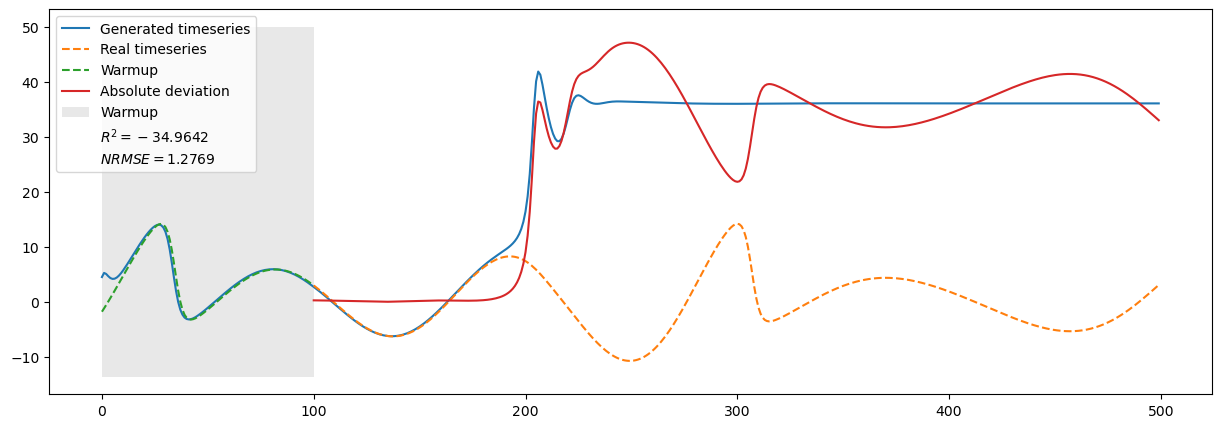

In [13]:
plot_generation(X_gen[:, :1], X_t[:, :1], nb_generations, warming_out=warming_out[:, :1],
                warming_inputs=warming_inputs[:, :1], seed_timesteps=seed_timesteps)

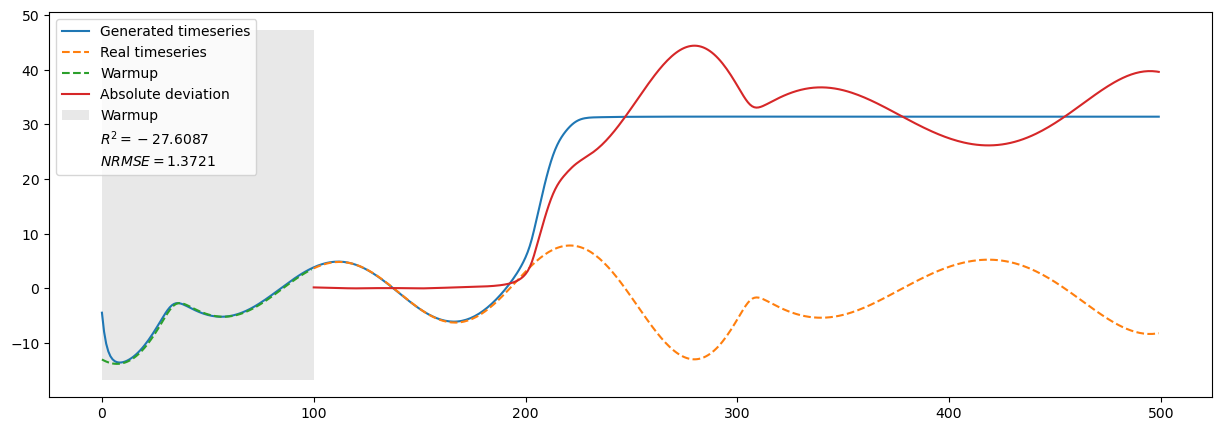

In [14]:
plot_generation(X_gen[:, 1:2], X_t[:, 1:2], nb_generations, warming_out=warming_out[:, 1:2],
                warming_inputs=warming_inputs[:, 1:2], seed_timesteps=seed_timesteps)

In [15]:
train_len = 4000 
forecast=1 

    
n, m = X.shape
    
from reservoirpy.datasets import to_forecasting

train_len = train_len

x, y = to_forecasting(X, forecast=forecast)
X_train, y_train = x[:train_len], y[:train_len]
X_test, y_test = x[train_len:], y[train_len:]

dataset = ((X_train, y_train), (X_test, y_test))

# bestから取得したハイパーパラメータを設定
N = 500
iss = 0.059936189081400526
lr = 0.38264094967620654
ridge = 1.8102732550311867e-05
seed = 1234
sr = 0.07966435869333038

# データセットからトレーニングとバリデーションデータを取得
train_data, validation_data = dataset
X_train, y_train = train_data
X_val, y_val = validation_data

# モデルの構築
reservoir = Reservoir(N, 
                    sr=sr, 
                    lr=lr, 
                    input_scaling=iss, 
                    seed=seed)
readout = Ridge(ridge=ridge)
model = reservoir >> readout

# モデルの訓練と予測
predictions = model.fit(X_train, y_train).run(X_val)


In [16]:
seed_timesteps = seed_timesteps
nb_generations = 1500
#実際は150ステップに対応

warming_inputs = X_test[:seed_timesteps]

warming_out = model.run(warming_inputs, reset=True)  # warmup
print(f"{warming_out[-1]}:warming_out[-1]")
print(f"{X_test[seed_timesteps]}:X_test[seed_timesteps]")
#warming_outはX_test[seed_timesteps]を近似する．

[-11.82821961   1.97605939  -1.4437301 ]:warming_out[-1]
[-11.82707987   1.9748284   -1.44405457]:X_test[seed_timesteps]


In [17]:
X_gen = np.zeros((nb_generations, m))
y = warming_out[-1] 
print(y.shape) 
y = y.reshape(1, -1) 
print(y.shape) #配列の形式は(n, m)の二次元配列にする必要があるので調整した


(3,)
(1, 3)


In [18]:
for t in range(nb_generations):  
    y[:, 2:3] = X_test[seed_timesteps+t, 2:3] #外力にあたる[:, 2:3]に実測値を代入する．
    y = model(y) #ESNで1回=0.1ステップ先を予測する．
    X_gen[t, :] = y #配列に記録していく
            
X_t = X_test[seed_timesteps: nb_generations+seed_timesteps]

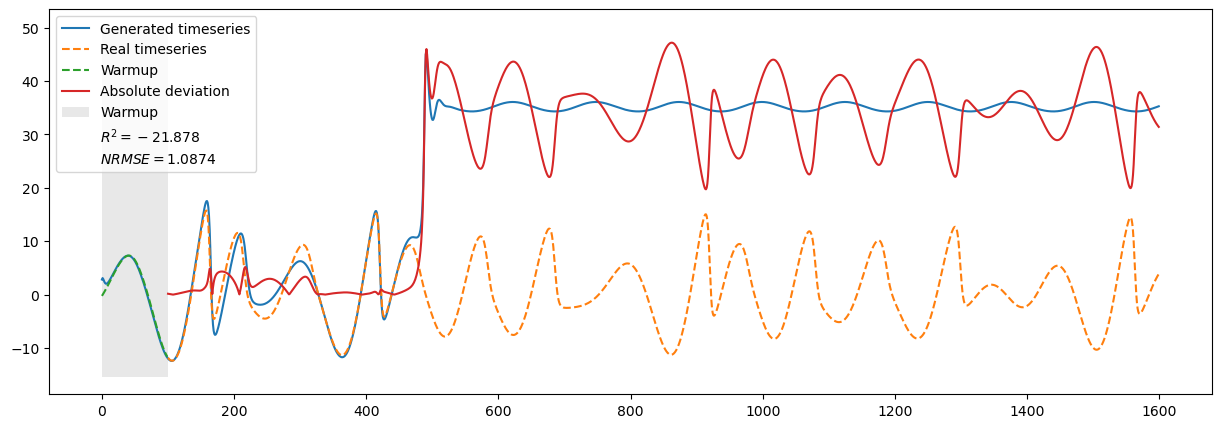

In [19]:
plot_generation(X_gen[:, :1], X_t[:, :1], nb_generations, warming_out=warming_out[:, :1],
                warming_inputs=warming_inputs[:, :1], seed_timesteps=seed_timesteps)

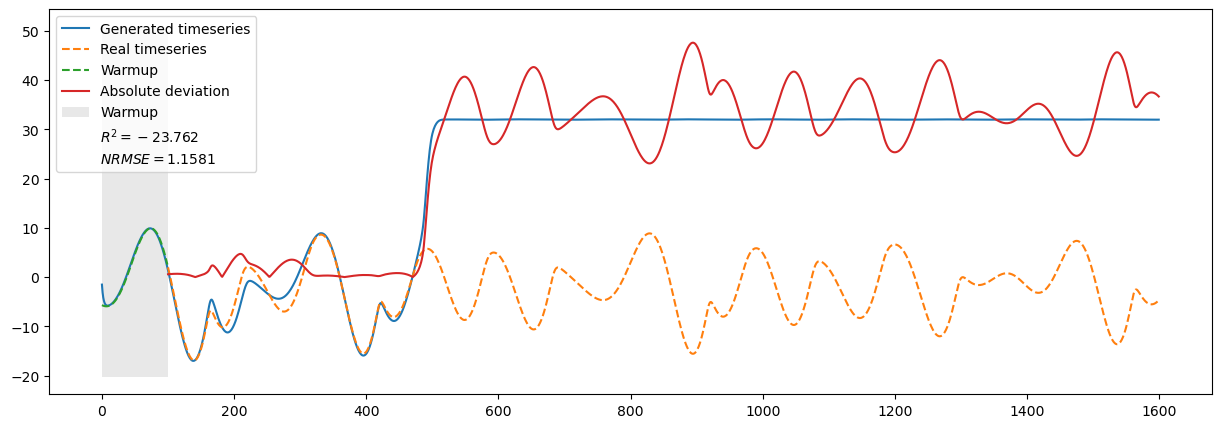

In [20]:
plot_generation(X_gen[:, 1:2], X_t[:, 1:2], nb_generations, warming_out=warming_out[:, 1:2],
                warming_inputs=warming_inputs[:, 1:2], seed_timesteps=seed_timesteps)